# Store Item Demand Forecasting Challenge
>https://www.kaggle.com/c/demand-forecasting-kernels-only/overview






Best Score <br>
Experiment 6: Ensembled model (Improved Prophet + Tuned Catboost + Rounding) <br>
Rank 98/459 on private leaderboard (top 21%) <br>
Rank 119/459 on public leaderboard (top 25%) <br>
<br>
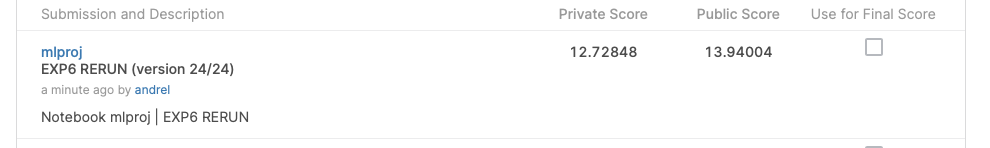

## Imports


In [150]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score

In [151]:
# train.csv
train_df = pd.read_csv("../input/confirm/train.csv")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [152]:
# test.csv
test_df = pd.read_csv("../input/confirm/test.csv")
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [153]:
# sample_submission.csv
sample_df = pd.read_csv("../input/confirm/sample_submission.csv")
sample_df.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


Exploration

## Data Preparation

In [154]:
from datetime import datetime

def convertYMD(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = [i.year for i in df['date']]
    df['month'] = [i.month for i in df['date']]
    df['day'] = [i.dayofweek for i in df['date']]

# Baseline ML Models

In [155]:
train_df = pd.read_csv("../input/confirm/train.csv")
train_df = train_df.reset_index()
train_df.rename(columns={'index': 'id'}, inplace=True)
train_df

,id,date,store,item,sales
0,0,2013-01-01,1,1,13
1,1,2013-01-02,1,1,11
2,2,2013-01-03,1,1,14
3,3,2013-01-04,1,1,13
4,4,2013-01-05,1,1,10
...,...,...,...,...,...
912995,912995,2017-12-27,10,50,63
912996,912996,2017-12-28,10,50,59
912997,912997,2017-12-29,10,50,74
912998,912998,2017-12-30,10,50,62


In [156]:
# split train_df into 2 validation and train set
val = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # first 3 months of 2017
train = pd.concat([train_df, val, val]).drop_duplicates(keep=False) # the rest of the months
val

,id,date,store,item,sales
1461,1461,2017-01-01,1,1,19
1462,1462,2017-01-02,1,1,15
1463,1463,2017-01-03,1,1,10
1464,1464,2017-01-04,1,1,16
1465,1465,2017-01-05,1,1,14
...,...,...,...,...,...
912720,912720,2017-03-27,10,50,66
912721,912721,2017-03-28,10,50,60
912722,912722,2017-03-29,10,50,73
912723,912723,2017-03-30,10,50,68


x-labels

In [157]:
convertYMD(train)
train.drop('date', axis=1, inplace=True)
train

,id,store,item,sales,year,month,day
0,0,1,1,13,2013,1,1
1,1,1,1,11,2013,1,2
2,2,1,1,14,2013,1,3
3,3,1,1,13,2013,1,4
4,4,1,1,10,2013,1,5
...,...,...,...,...,...,...,...
912995,912995,10,50,63,2017,12,2
912996,912996,10,50,59,2017,12,3
912997,912997,10,50,74,2017,12,4
912998,912998,10,50,62,2017,12,5


In [158]:
convertYMD(val)
val.drop('date', axis=1, inplace=True)
val

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,id,store,item,sales,year,month,day
1461,1461,1,1,19,2017,1,6
1462,1462,1,1,15,2017,1,0
1463,1463,1,1,10,2017,1,1
1464,1464,1,1,16,2017,1,2
1465,1465,1,1,14,2017,1,3
...,...,...,...,...,...,...,...
912720,912720,10,50,66,2017,3,0
912721,912721,10,50,60,2017,3,1
912722,912722,10,50,73,2017,3,2
912723,912723,10,50,68,2017,3,3


y-labels

In [159]:
sales_val = val.pop('sales')
sales_val

1461      19
1462      15
1463      10
1464      16
1465      14
          ..
912720    66
912721    60
912722    73
912723    68
912724    69
Name: sales, Length: 45000, dtype: int64

In [160]:
sales_train = train.pop('sales')
sales_train

0         13
1         11
2         14
3         13
4         10
          ..
912995    63
912996    59
912997    74
912998    62
912999    82
Name: sales, Length: 868000, dtype: int64

In [161]:
test_df

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1
...,...,...,...,...
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50


In [162]:
print(train.shape, val.shape, test_df.shape)

(868000, 6) (45000, 6) (45000, 4)


In [163]:
def regression_report(y_true, y_pred):
    metrics = [('SMAPE', (100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_pred) + np.abs(y_true))))),
               ('MAE', mean_absolute_error(y_true, y_pred)),
               ('Median Absolute Error', median_absolute_error(y_true, y_pred)),
               ('Mean Squared Error', mean_squared_error(y_true, y_pred)),
               ('Max Error', max_error(y_true, y_pred)),
               ('R2 Score', r2_score(y_true, y_pred)),
               ('Explained Variance Score', explained_variance_score(y_true, y_pred))]

    # Init scoring metrics
    regression_report_df = pd.DataFrame(columns=['Metric Name', 'Score'])
    dfs = []
    for name, score in metrics:
        df = pd.DataFrame([[name, score]], columns=['Metric Name', 'Score'])
        dfs.append(df)
    regression_report_df = pd.concat(dfs, ignore_index=True)
              
    return regression_report_df

## Catboost

In [164]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds = 20, eval_set=(val.values, sales_val.values))

0:	learn: 25.5797383	test: 21.9989298	best: 21.9989298 (0)	total: 154ms	remaining: 30.6s
1:	learn: 23.6143066	test: 20.0438044	best: 20.0438044 (1)	total: 296ms	remaining: 29.3s
2:	learn: 22.1105882	test: 18.9344326	best: 18.9344326 (2)	total: 436ms	remaining: 28.7s
3:	learn: 20.9367829	test: 17.8755775	best: 17.8755775 (3)	total: 574ms	remaining: 28.1s
4:	learn: 19.9988650	test: 16.9044698	best: 16.9044698 (4)	total: 713ms	remaining: 27.8s
5:	learn: 19.1847006	test: 16.3222385	best: 16.3222385 (5)	total: 850ms	remaining: 27.5s
6:	learn: 18.6610887	test: 16.0018270	best: 16.0018270 (6)	total: 989ms	remaining: 27.3s
7:	learn: 17.9454901	test: 15.2336801	best: 15.2336801 (7)	total: 1.13s	remaining: 27s
8:	learn: 17.5120643	test: 14.7968417	best: 14.7968417 (8)	total: 1.26s	remaining: 26.8s
9:	learn: 16.5783591	test: 13.9977536	best: 13.9977536 (9)	total: 1.4s	remaining: 26.6s
10:	learn: 15.5051255	test: 12.9447770	best: 12.9447770 (10)	total: 1.54s	remaining: 26.5s
11:	learn: 15.0481379	

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,13.470677
1,MAE,5.308890
2,Median Absolute Error,4.244043
3,Mean Squared Error,47.227441
4,Max Error,36.376568
5,R2 Score,0.916615
6,Explained Variance Score,0.916844


In [ ]:
y_pred = model.predict(test_df.values)

sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_cb.csv", index=False)
sample_df.head()

,id,sales
0,0,12.024849
1,1,13.822182
2,2,13.872539
3,3,14.491420
4,4,15.831704


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(train.values, sales_train.values)

DecisionTreeRegressor()

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.971560
1,MAE,5.914089
2,Median Absolute Error,4.750000
3,Mean Squared Error,59.487114
4,Max Error,46.250000
5,R2 Score,0.894970
6,Explained Variance Score,0.899911


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_dt.csv", index=False)
sample_df.head()

,id,sales
0,0,10.25
1,1,15.00
2,2,13.00
3,3,14.75
4,4,15.40


## LightGBM

In [ ]:
from lightgbm import LGBMRegressor

model = LGBMRegressor()
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds=20, eval_set=(val.values, sales_val.values))

C:\Users\nct\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\nct\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l2: 584.19

[2]	valid_0's l2: 561.64

[3]	valid_0's l2: 524.281

[4]	valid_0's l2: 506.43

[5]	valid_0's l2: 473.732

[6]	valid_0's l2: 450.229

[7]	valid_0's l2: 428.166

[8]	valid_0's l2: 416.79

[9]	valid_0's l2: 394.807

[10]	valid_0's l2: 374.03

[11]	valid_0's l2: 363.919

[12]	valid_0's l2: 361.482

[13]	valid_0's l2: 342.619

[14]	valid_0's l2: 330.144

[15]	valid_0's l2: 300.307

[16]	valid_0's l2: 297.294

[17]	valid_0's l2: 268.072

[18]	valid_0's l2: 257.175

[19]	valid_0's l2: 254.052

[20]	valid_0's l2: 247.8

[21]	valid_0's l2: 225.654

[22]	valid_0's l2: 227.765

[23]	valid_0's l2: 223.403

[24]	valid_0's l2: 217.933

[25]	valid_0's l2: 214.066

[26]	valid_0's l2: 204.363

[27]	valid_0's l2: 202.691

[28]	valid_0's l2: 198.104

[29]	valid_0's l2: 199.247

[30]	valid_0's l2: 196.216

[31]	valid_0's l2: 181.023

[32]	valid_0's l2: 176.559

[33]	valid_0's l2: 174.482

[34]	valid_0's l2: 163.458

[35]	valid_0's l2: 158.113

[36]	valid_0's l2: 154.468

[37]	val

LGBMRegressor()

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,16.073213
1,MAE,6.260856
2,Median Absolute Error,5.224466
3,Mean Squared Error,63.384272
4,Max Error,49.278440
5,R2 Score,0.888089
6,Explained Variance Score,0.892342


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_lgbm.csv", index=False)
sample_df.head()

,id,sales
0,0,16.561062
1,1,17.444016
2,2,17.444016
3,3,18.268907
4,4,17.977213


## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train.values, sales_train.values)

LinearRegression()

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,48.924073
1,MAE,22.670578
2,Median Absolute Error,21.663495
3,Mean Squared Error,717.115720
4,Max Error,90.322757
5,R2 Score,-0.266139
6,Explained Variance Score,0.066234


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_lr.csv", index=False)
sample_df.head()

,id,sales
0,0,57.005051
1,1,60.219296
2,2,63.433540
3,3,66.647785
4,4,69.862029


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, n_jobs=-1)
model.fit(train.values, sales_train.values)

RandomForestRegressor(n_estimators=200, n_jobs=-1)

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.939864
1,MAE,5.903299
2,Median Absolute Error,4.701825
3,Mean Squared Error,59.287404
4,Max Error,45.934653
5,R2 Score,0.895322
6,Explained Variance Score,0.900283


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_rf.csv", index=False)
sample_df.head()

,id,sales
0,0,10.285578
1,1,14.938321
2,2,12.882200
3,3,14.679198
4,4,15.437772


## XGBoost

In [ ]:
import xgboost
model = xgboost.XGBRegressor(n_estimators = 200, seed = 21)
model.fit(train.values, sales_train.values, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=21,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,14.064043
1,MAE,5.522580
2,Median Absolute Error,4.433034
3,Mean Squared Error,50.913739
4,Max Error,38.642258
5,R2 Score,0.910107
6,Explained Variance Score,0.910661


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_xgb.csv", index=False)
sample_df.head()

,id,sales
0,0,14.757501
1,1,16.119011
2,2,16.984201
3,3,13.956003
4,4,15.874704


## MLP (Neural Network)

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(32,32,32), activation="relu", random_state=1, max_iter=20).fit(train.values, sales_train.values)

C:\Users\nct\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.

  warnings.warn(


In [ ]:
y_pred = model.predict(val.values)
regression_report(sales_val.values, y_pred)

,Metric Name,Score
0,SMAPE,37.410320
1,MAE,15.518736
2,Median Absolute Error,12.422675
3,Mean Squared Error,406.063925
4,Max Error,102.058914
5,R2 Score,0.283054
6,Explained Variance Score,0.323098


In [ ]:
# predict test data
y_pred = model.predict(test_df.values)
sample_df = pd.read_csv("sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.to_csv("submission_mlp.csv", index=False)
sample_df.head()

,id,sales
0,0,4.529868
1,1,5.776620
2,2,7.023372
3,3,8.831623
4,4,10.765563


# Prophet

In [52]:
# !pip install prophet
# !pip install --upgrade plotly
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation

In [53]:
train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0 # init sales col

result_df = pd.DataFrame(columns = ['sales'])

stores = train['store'].unique()
items = train['item'].unique()
period = len(test.index.unique())

# run the model through each of the 10 stores and 50 items
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet()
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
07:22:30 - cmdstanpy - INFO - Chain [1] start processing
07:22:31 - cmdstanpy - INFO - Chain [1] done processing
07:22:31 - cmdstanpy - INFO - Chain [1] start processing
07:22:31 - cmdstanpy - INFO - Chain [1] done processing
07:22:32 - cmdstanpy - INFO

In [54]:
result_df.head()

,sales,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,3.012006,2017-01-01,3.121067,2.700150,3.281753,3.121067,3.121067,-0.109061,-0.109061,-0.109061,0.178424,0.178424,0.178424,-0.287485,-0.287485,-0.287485,0.0,0.0,0.0,3.012006
1,2.605860,2017-01-02,3.121271,2.296531,2.885458,3.121271,3.121271,-0.515410,-0.515410,-0.515410,-0.227879,-0.227879,-0.227879,-0.287531,-0.287531,-0.287531,0.0,0.0,0.0,2.605860
2,2.752642,2017-01-03,3.121475,2.444837,3.032027,3.121475,3.121475,-0.368833,-0.368833,-0.368833,-0.080215,-0.080215,-0.080215,-0.288618,-0.288618,-0.288618,0.0,0.0,0.0,2.752642
3,2.783850,2017-01-04,3.121678,2.489008,3.082092,3.121678,3.121678,-0.337829,-0.337829,-0.337829,-0.047165,-0.047165,-0.047165,-0.290664,-0.290664,-0.290664,0.0,0.0,0.0,2.783850
4,2.800618,2017-01-05,3.121882,2.507491,3.098214,3.121882,3.121882,-0.321265,-0.321265,-0.321265,-0.027708,-0.027708,-0.027708,-0.293557,-0.293557,-0.293557,0.0,0.0,0.0,2.800618


In [55]:
val = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
val = val.reset_index()
val.sales

0        19
1        15
2        10
3        16
4        14
         ..
44995    66
44996    60
44997    73
44998    68
44999    69
Name: sales, Length: 45000, dtype: int64

In [56]:
regression_report(val.sales, result_df['sales'])

,Metric Name,Score
0,SMAPE,161.341230
1,MAE,42.047173
2,Median Absolute Error,38.530493
3,Mean Squared Error,2329.328461
4,Max Error,156.645397
5,R2 Score,-3.112660
6,Explained Variance Score,0.008833


In [57]:
df = result_df['sales']
df2 = pd.DataFrame(df)
df2.columns.values[0] = "id"
df2

,id
0,3.012006
1,2.605860
2,2.752642
3,2.783850
4,2.800618
...,...
44995,4.206875
44996,4.354169
44997,4.373866
44998,4.442172


In [58]:
df2 = result_df['sales']
df2 = df2.reset_index()
df2.rename(columns={'index': 'id'}, inplace=True)
df2.to_csv('submission.csv', index=False)


## Improving Prophet: With Prophet built in holidays

In [59]:
train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0

result_df = pd.DataFrame(columns = ['sales'])

stores = train_df['store'].unique()
items = train_df['item'].unique()

# run the model through each of the 10 stores and 50 items
for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.add_country_holidays(country_name='US')
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
07:35:26 - cmdstanpy - INFO - Chain [1] start processing
07:35:26 - cmdstanpy - INFO - Chain [1] done processing
07:35:27 - cmdstanpy - INFO - Chain [1] start processing
07:35:27 - cmdstanpy - INFO - Chain [1] done processing
07:35:28 - cmdstanpy - INFO

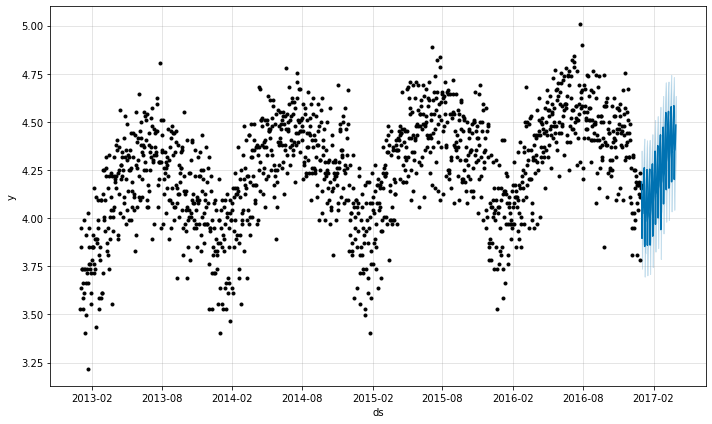

In [60]:
forecastplot = model.plot(forecast)

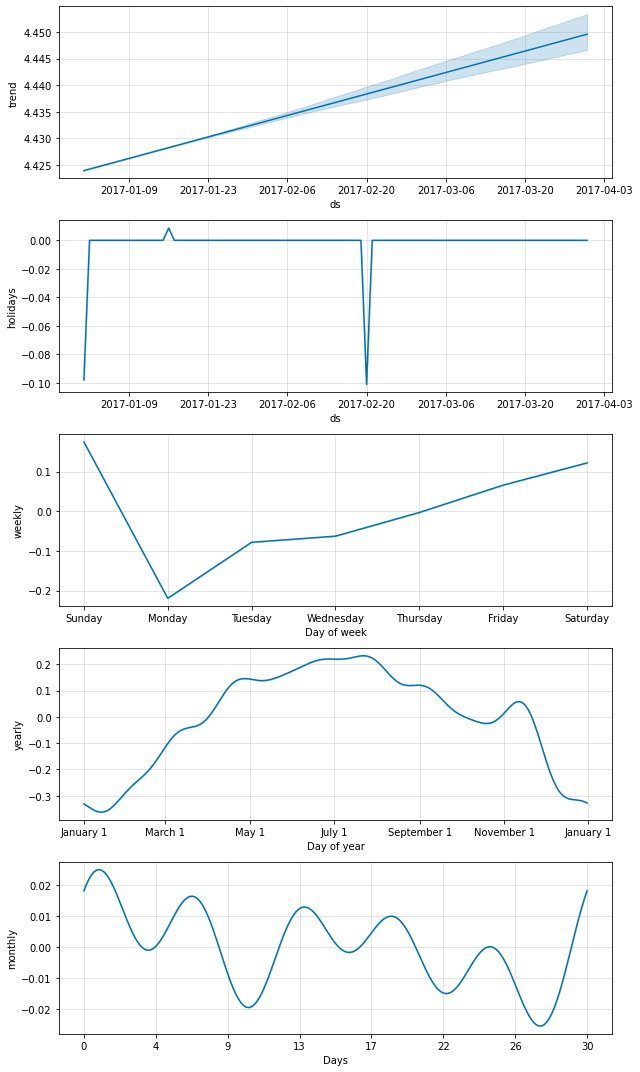

In [61]:
fig = model.plot_components(forecast)

In [62]:
test_results = result_df['sales']
test_results = np.round(test_results).astype(int) 

In [63]:
regression_report(val.sales, test_results)

,Metric Name,Score
0,SMAPE,161.491269
1,MAE,42.063778
2,Median Absolute Error,39.000000
3,Mean Squared Error,2330.687156
4,Max Error,157.000000
5,R2 Score,-3.115059
6,Explained Variance Score,0.008897


In [64]:
# rounded off results is better than non-rounded
df2 = test_results
df2 = df2.reset_index()
df2.rename(columns={'index': 'id'}, inplace=True)
df2
df2.to_csv('submission.csv', index=False) 

In [65]:
model.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11    Independence Day (Observed)
dtype: object

## Improving Prophet: With holiday dataset from Kaggle

In [66]:
holidays = pd.read_csv("../input/us-holiday-dates-2004-2021/US Holiday Dates (2004-2021).csv")
holidays.head()

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [67]:
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays = holidays[(holidays['ds']>holidays.iloc[0]['ds'])&(holidays['ds']<holidays.iloc[-1]['ds'])]
results = test.reset_index()
results['sales'] = 0
period = len(test.index.unique())

In [68]:
train = train_df.loc[(train_df["date"] < "2017-01-01"), :] # everything else before that
train['date'] = pd.to_datetime(train['date'])
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :] # First 3 months of 2017
test['date'] = pd.to_datetime(test['date'])

results = test.reset_index()
results['sales'] = 0

result_df = pd.DataFrame(columns = ['sales'])

stores = train_df['store'].unique()
items = train_df['item'].unique()

for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y']) # log transform
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat']
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)
       

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
07:45:38 - cmdstanpy - INFO - Chain [1] start processing
07:45:38 - cmdstanpy - INFO - Chain [1] done processing
07:45:39 - cmdstanpy - INFO - Chain [1] start processing
07:45:39 - cmdstanpy - INFO - Chain [1] done processing
07:45:40 - cmdstanpy - INFO

In [69]:
result_df['sales'] = np.round(result_df['sales']) # round to whole number
df2 = result_df['sales']
df2 = df2.reset_index()
df2.rename(columns={'index': 'id'}, inplace=True)
df2.to_csv('submission.csv', index=False) 

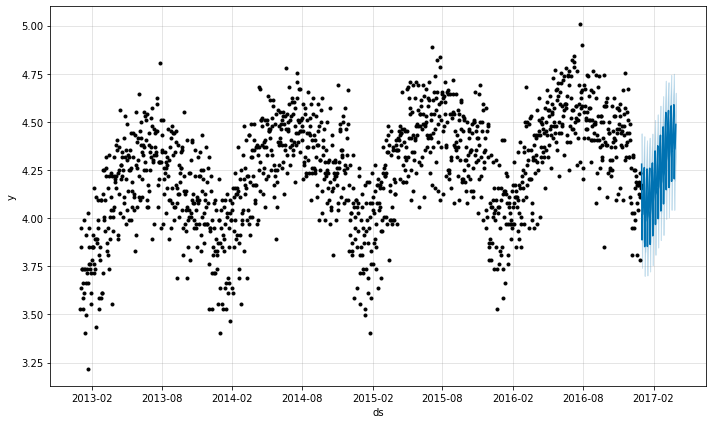

In [70]:
forecastplot = model.plot(forecast)

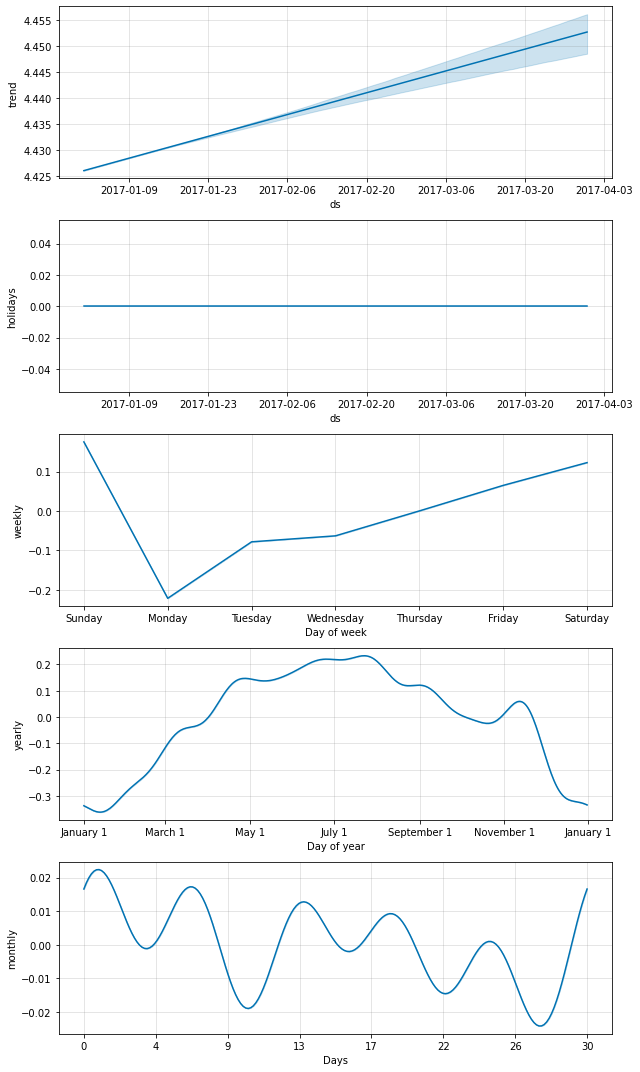

In [71]:
fig = model.plot_components(forecast)

In [72]:
test_results = result_df['sales']
test_results

0        3.0
1        3.0
2        3.0
3        3.0
4        3.0
        ... 
44995    4.0
44996    4.0
44997    4.0
44998    4.0
44999    4.0
Name: sales, Length: 45000, dtype: float64

In [73]:
regression_report(val.sales, test_results)

,Metric Name,Score
0,SMAPE,161.486983
1,MAE,42.063444
2,Median Absolute Error,39.000000
3,Mean Squared Error,2330.674778
4,Max Error,157.000000
5,R2 Score,-3.115037
6,Explained Variance Score,0.008870


## Improving Prophet: Seasonality (fourier order 3 instead of 5)

In [74]:
test = train_df.loc[(train_df["date"] >= "2017-01-01") & (train_df["date"] < "2017-04-01"), :]
results = test.reset_index()
results['sales']
period = len(test.index.unique())

for s in stores:
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=3)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=90, include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = forecast['yhat'].values
        forecast['sales'] = forecast['yhat']
        result_df = pd.concat([result_df, forecast], ignore_index=True)
        

07:59:24 - cmdstanpy - INFO - Chain [1] start processing
07:59:24 - cmdstanpy - INFO - Chain [1] done processing
07:59:25 - cmdstanpy - INFO - Chain [1] start processing
07:59:25 - cmdstanpy - INFO - Chain [1] done processing
07:59:26 - cmdstanpy - INFO - Chain [1] start processing
07:59:26 - cmdstanpy - INFO - Chain [1] done processing
07:59:27 - cmdstanpy - INFO - Chain [1] start processing
07:59:27 - cmdstanpy - INFO - Chain [1] done processing
07:59:28 - cmdstanpy - INFO - Chain [1] start processing
07:59:28 - cmdstanpy - INFO - Chain [1] done processing
07:59:28 - cmdstanpy - INFO - Chain [1] start processing
07:59:29 - cmdstanpy - INFO - Chain [1] done processing
07:59:30 - cmdstanpy - INFO - Chain [1] start processing
07:59:30 - cmdstanpy - INFO - Chain [1] done processing
07:59:30 - cmdstanpy - INFO - Chain [1] start processing
07:59:31 - cmdstanpy - INFO - Chain [1] done processing
07:59:31 - cmdstanpy - INFO - Chain [1] start processing
07:59:32 - cmdstanpy - INFO - Chain [1]

In [75]:
results.drop(['date', 'store', 'item', 'index'], axis=1, inplace=True)
results

,id,sales
0,1461,3.008680
1,1462,2.602626
2,1463,2.749148
3,1464,2.780222
4,1465,2.797338
...,...,...
44995,912720,4.197370
44996,912721,4.342945
44997,912722,4.361753
44998,912723,4.430499


In [78]:
results.to_csv('submission_prophet_1.csv', index=False)

In [89]:
# rounding
results['sales'] = np.round(results['sales']).astype(int)
test_results = results['sales']
results.to_csv('submission_prophet4.csv', index=False)

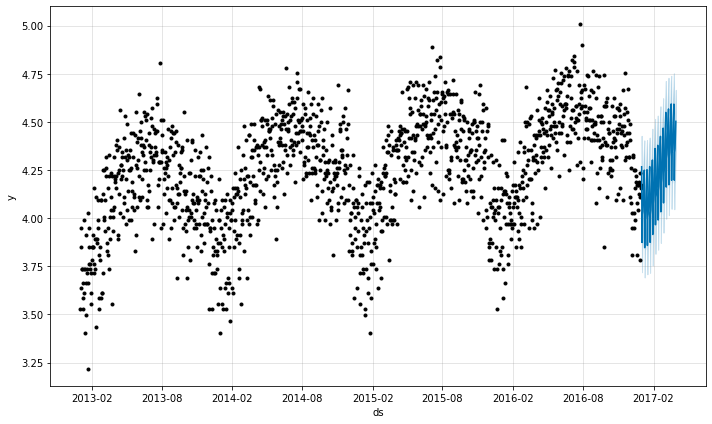

In [90]:
forecastplot = model.plot(forecast)

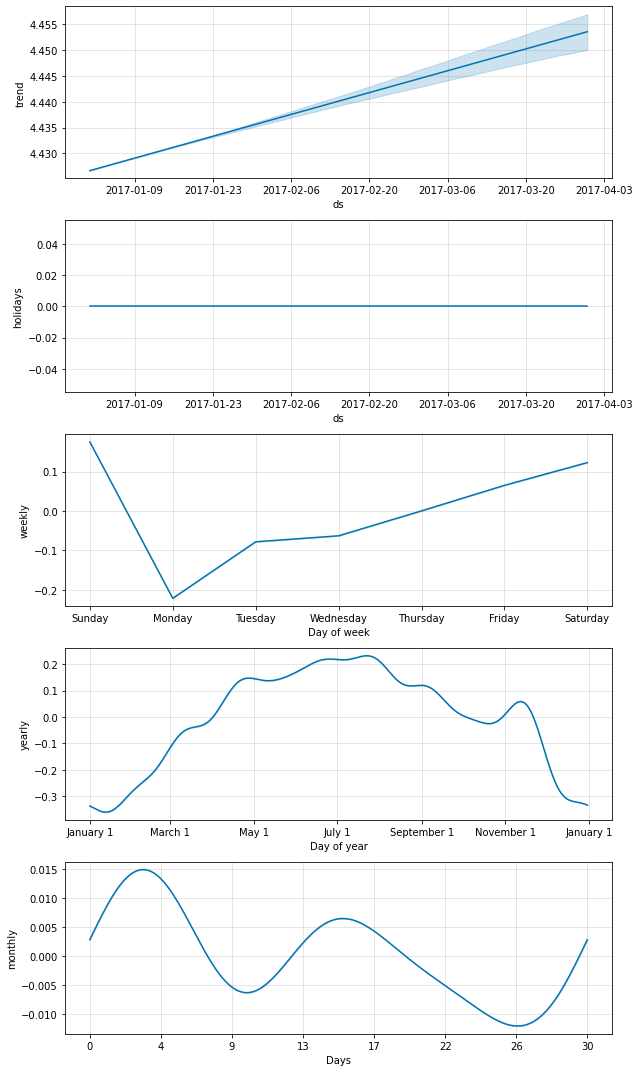

In [91]:
fig = model.plot_components(forecast)

In [92]:
regression_report(val.sales, test_results)

,Metric Name,Score
0,SMAPE,163.109948
1,MAE,42.063200
2,Median Absolute Error,38.000000
3,Mean Squared Error,2313.815956
4,Max Error,156.000000
5,R2 Score,-3.085271
6,Explained Variance Score,0.038626


# Proposed Solution

## Retraining Best Baseline Model - Catboost


> Previously, the baseline models were trained on segmented data to evaluate the performance of each model. As Prophet was trained with the entire training dataset provided without splitting, the catboost model will be trained here in entirety. 



In [1]:
!pip install catboost

In [165]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds = 20)



#model = CatBoostRegressor(max_depth=10, loss_function='RMSE', n_estimators = 200, eta = 0.3, random_seed=1)
#model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds = 20, eval_set=(val.values, sales_val.values))

0:	learn: 25.5797383	total: 156ms	remaining: 31.1s
1:	learn: 23.6143066	total: 301ms	remaining: 29.8s
2:	learn: 22.1105882	total: 443ms	remaining: 29.1s
3:	learn: 20.9367829	total: 587ms	remaining: 28.8s
4:	learn: 19.9988650	total: 731ms	remaining: 28.5s
5:	learn: 19.1847006	total: 871ms	remaining: 28.2s
6:	learn: 18.6610887	total: 1.01s	remaining: 28s
7:	learn: 17.9454901	total: 1.16s	remaining: 27.8s
8:	learn: 17.5120643	total: 1.3s	remaining: 27.6s
9:	learn: 16.5783591	total: 1.44s	remaining: 27.4s
10:	learn: 15.5051255	total: 1.59s	remaining: 27.3s
11:	learn: 15.0481379	total: 1.73s	remaining: 27s
12:	learn: 14.5420408	total: 1.86s	remaining: 26.8s
13:	learn: 13.8840291	total: 2s	remaining: 26.6s
14:	learn: 13.2143922	total: 2.15s	remaining: 26.5s
15:	learn: 13.0192386	total: 2.28s	remaining: 26.2s
16:	learn: 12.6804819	total: 2.42s	remaining: 26.1s
17:	learn: 12.3743614	total: 2.57s	remaining: 26s
18:	learn: 11.8211827	total: 2.71s	remaining: 25.8s
19:	learn: 11.6733655	total: 2.8

In [166]:
y_pred = model.predict(val.values)

In [167]:
# init sample_submission.csv
sample_df = pd.read_csv("../input/confirm/sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.head()

,id,sales
0,0,17.511682
1,1,10.884275
2,2,14.331269
3,3,14.339889
4,4,15.386526


In [168]:
sample_df.to_csv("submission_catboost.csv", index=False)

## Ensembling Experiments (Before Tuning)

Experiment 1 (without rounding)

In [80]:
# both df had no rounding
import pandas as pd
df1 = pd.read_csv("./submission_catboost.csv")
df2 = pd.read_csv("./submission_prophet_1.csv")

In [81]:
df1.head(3)

,id,sales
0,0,17.511682
1,1,10.884275
2,2,14.331269


In [82]:
df2.head(3)

,id,sales
0,1461,3.008680
1,1462,2.602626
2,1463,2.749148


In [83]:
df3 = df1 # make a duplicate
df3['sales'] = (0.5*df1['sales']) + (0.5*df2['sales'])

In [84]:
df3

,id,sales
0,0,10.260181
1,1,6.743451
2,2,8.540208
3,3,8.560055
4,4,9.091932
...,...,...
44995,44995,31.961019
44996,44996,37.268047
44997,44997,37.265767
44998,44998,40.132278


In [86]:
df3.to_csv('submission_ens.csv', index=False) 

Experiment 2 (with rounding)

In [88]:
import numpy as np
df4 = df3
df4['sales'] = np.round(df4['sales']).astype(int) # round the result to whole number

In [89]:
df4

,id,sales
0,0,10
1,1,7
2,2,9
3,3,9
4,4,9
...,...,...
44995,44995,32
44996,44996,37
44997,44997,37
44998,44998,40


In [91]:
df4.to_csv('submission_ens2.csv', index=False)

Experiment 3 (changing weightage p1)

In [92]:
df5 = df1 # make a duplicate
df5['sales'] = (0.4*df1['sales']) + (0.6*df2['sales'])

In [93]:
df5

,id,sales
0,0,5.805208
1,1,4.361576
2,2,5.249489
3,3,5.268133
4,4,5.278403
...,...,...
44995,44995,15.318422
44996,44996,17.405767
44997,44997,17.417052
44998,44998,18.658300


Experiment 4 (changing weightage p2)

In [94]:
df6 = df1 # make a duplicate
df6['sales'] = (0.6*df1['sales']) + (0.4*df2['sales'])

In [95]:
df6

,id,sales
0,0,4.686597
1,1,3.657996
2,2,4.249352
3,3,4.272969
4,4,4.285977
...,...,...
44995,44995,10.870001
44996,44996,12.180638
44997,44997,12.194932
44998,44998,12.967179


In [97]:
df6.to_csv('submission_ens4.csv', index=False)

In [98]:
import numpy as np
df6_rounded = df6
df6_rounded['sales'] = np.round(df6_rounded['sales']).astype(int) # round the result to whole number

In [99]:
df6_rounded

,id,sales
0,0,5
1,1,4
2,2,4
3,3,4
4,4,4
...,...,...
44995,44995,11
44996,44996,12
44997,44997,12
44998,44998,13


In [100]:
df6_rounded.to_csv('submission_ens4_rounded.csv', index=False)

## Improving Catboost

In [ ]:
!pip install catboost

Gridsearch, 3-fold cross validation

In [124]:
from catboost import CatBoostRegressor
import numpy as np

model = CatBoostRegressor()

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'max_depth': [8, 10, 12],
        'n_estimators': [100, 200, 300]}

grid_search_result = model.grid_search(grid, cv=3,
                                       X=train.values,
                                       y=sales_train.values,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 58.5181536	test: 58.4945102	best: 58.4945102 (0)	total: 105ms	remaining: 10.4s
1:	learn: 57.0679278	test: 57.0438157	best: 57.0438157 (1)	total: 193ms	remaining: 9.46s
2:	learn: 55.6335642	test: 55.6070586	best: 55.6070586 (2)	total: 279ms	remaining: 9.03s
3:	learn: 54.2679335	test: 54.2408629	best: 54.2408629 (3)	total: 370ms	remaining: 8.89s
4:	learn: 52.9346783	test: 52.9062262	best: 52.9062262 (4)	total: 459ms	remaining: 8.72s
5:	learn: 51.6428490	test: 51.6132538	best: 51.6132538 (5)	total: 552ms	remaining: 8.65s
6:	learn: 50.4115747	test: 50.3815297	best: 50.3815297 (6)	total: 643ms	remaining: 8.55s
7:	learn: 49.2267290	test: 49.1960432	best: 49.1960432 (7)	total: 730ms	remaining: 8.4s
8:	learn: 48.0672711	test: 48.0359075	best: 48.0359075 (8)	total: 815ms	remaining: 8.24s
9:	learn: 46.9440039	test: 46.9111019	best: 46.9111019 (9)	total: 904ms	remaining: 8.13s
10:	learn: 45.8685251	test: 45.8357196	best: 45.8357196 (10)	total: 993ms	remaining: 8.03s
11:	learn: 44.825402

In [125]:
grid_search_result['params']

{'depth': 12, 'iterations': 300, 'learning_rate': 0.3}

Results based on the best parameters

In [128]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', eval_metric='SMAPE', n_estimators = 300, learning_rate = 0.3, random_seed=1)
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds=20)

0:	learn: 41.6026693	total: 142ms	remaining: 42.5s
1:	learn: 38.5884620	total: 283ms	remaining: 42.2s
2:	learn: 36.3777428	total: 423ms	remaining: 41.9s
3:	learn: 34.4428166	total: 561ms	remaining: 41.5s
4:	learn: 32.7338535	total: 700ms	remaining: 41.3s
5:	learn: 31.3064618	total: 841ms	remaining: 41.2s
6:	learn: 30.4511950	total: 981ms	remaining: 41.1s
7:	learn: 28.9270924	total: 1.12s	remaining: 40.9s
8:	learn: 27.9633770	total: 1.28s	remaining: 41.4s
9:	learn: 26.6177766	total: 1.44s	remaining: 41.6s
10:	learn: 24.9168020	total: 1.58s	remaining: 41.4s
11:	learn: 24.2502185	total: 1.72s	remaining: 41.2s
12:	learn: 23.2155544	total: 1.86s	remaining: 41.1s
13:	learn: 22.0020458	total: 2s	remaining: 40.9s
14:	learn: 21.1402537	total: 2.14s	remaining: 40.7s
15:	learn: 20.7219267	total: 2.28s	remaining: 40.5s
16:	learn: 20.0447555	total: 2.42s	remaining: 40.3s
17:	learn: 19.6402037	total: 2.56s	remaining: 40.1s
18:	learn: 18.7863287	total: 2.7s	remaining: 39.9s
19:	learn: 18.4378389	tota

In [130]:
y_pred = model.predict(val.values)

In [131]:
# init sample_submission.csv
sample_df = pd.read_csv("../input/confirm/sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.head()

,id,sales
0,0,17.989182
1,1,11.999386
2,2,15.324741
3,3,15.341722
4,4,15.653618


In [132]:
sample_df.to_csv("submission_catboost_2.csv", index=False)

In [133]:
sample_df

,id,sales
0,0,17.989182
1,1,11.999386
2,2,15.324741
3,3,15.341722
4,4,15.653618
...,...,...
44995,44995,59.696863
44996,44996,70.074153
44997,44997,71.091680
44998,44998,76.491307


Results based on the best parameters (different random seed)

In [134]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

model = CatBoostRegressor(max_depth=10, loss_function='RMSE', eval_metric='SMAPE', n_estimators = 300, learning_rate = 0.3, random_seed=21)
model.fit(train.values, sales_train.values, verbose=True, early_stopping_rounds=20)


0:	learn: 41.6061799	total: 162ms	remaining: 48.3s
1:	learn: 38.7127958	total: 313ms	remaining: 46.7s
2:	learn: 36.1553331	total: 463ms	remaining: 45.8s
3:	learn: 34.0939082	total: 615ms	remaining: 45.5s
4:	learn: 32.2118152	total: 765ms	remaining: 45.2s
5:	learn: 30.6221571	total: 919ms	remaining: 45s
6:	learn: 29.6337402	total: 1.07s	remaining: 44.9s
7:	learn: 27.8579590	total: 1.23s	remaining: 44.8s
8:	learn: 26.7682809	total: 1.38s	remaining: 44.6s
9:	learn: 26.2465045	total: 1.54s	remaining: 44.5s
10:	learn: 25.0177479	total: 1.69s	remaining: 44.5s
11:	learn: 23.9017474	total: 1.84s	remaining: 44.2s
12:	learn: 22.9697672	total: 2s	remaining: 44.1s
13:	learn: 21.9676426	total: 2.15s	remaining: 43.9s
14:	learn: 21.4494327	total: 2.3s	remaining: 43.6s
15:	learn: 20.7229850	total: 2.44s	remaining: 43.4s
16:	learn: 20.4863663	total: 2.6s	remaining: 43.2s
17:	learn: 20.1258002	total: 2.78s	remaining: 43.6s
18:	learn: 19.1956149	total: 2.94s	remaining: 43.5s
19:	learn: 18.8669580	total: 

In [135]:
y_pred = model.predict(val.values)

In [136]:
# init sample_submission.csv
sample_df = pd.read_csv("../input/confirm/sample_submission.csv")
sample_df['sales'] = y_pred
sample_df.head()

,id,sales
0,0,17.303167
1,1,12.437742
2,2,15.133710
3,3,15.279426
4,4,15.850829


In [137]:
sample_df.to_csv("submission_catboost_3.csv", index=False)

In [138]:
sample_df

,id,sales
0,0,17.303167
1,1,12.437742
2,2,15.133710
3,3,15.279426
4,4,15.850829
...,...,...
44995,44995,59.444580
44996,44996,69.736595
44997,44997,70.240818
44998,44998,75.885179


## Improving Prophet

In [139]:
# !pip install fbprophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation
import numpy as np

In [140]:
import pandas as pd
# train.csv
train_df = pd.read_csv("../input/confirm/train.csv")
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [142]:
train_df.rename(columns = {'date':'ds', 'sales':'y'}, inplace = True)

Included unofficial holidays like black friday

In [143]:
holidays = pd.read_csv("../input/unoffical/Holiday_updated.csv")
holidays.loc[385:388]

,Date,Holiday,WeekDay,Month,Day,Year
385,12/12/2011,12/12 Sales,Tuesday,12,12,2011
386,12/12/2012,12/12 Sales,Thursday,12,12,2012
387,12/12/2013,12/12 Sales,Friday,12,12,2013
388,12/12/2014,12/12 Sales,Saturday,12,12,2014


In [144]:
holidays = pd.read_csv("../input/unoffical/Holiday_updated.csv")
holidays.rename(columns={"Date": "ds", "Holiday": "holiday"},inplace=True)
holidays['ds'] = pd.to_datetime(holidays['ds']) 
holidays

,ds,holiday,WeekDay,Month,Day,Year
0,2004-04-07,4th of July,Sunday,7,4,2004
1,2005-04-07,4th of July,Monday,7,4,2005
2,2006-04-07,4th of July,Tuesday,7,4,2006
3,2007-04-07,4th of July,Wednesday,7,4,2007
4,2008-04-07,4th of July,Friday,7,4,2008
...,...,...,...,...,...,...
427,2017-11-27,Cyber Monday Sales,Monday,11,27,2017
428,2018-11-26,Cyber Monday Sales,Monday,11,26,2018
429,2019-02-12,Cyber Monday Sales,Monday,12,2,2019
430,2020-11-30,Cyber Monday Sales,Monday,11,30,2020


Seasonality

In [145]:
train = pd.read_csv("../input/confirm/train.csv", parse_dates=['date'], index_col=['date'])
test = pd.read_csv("../input/confirm/test.csv", parse_dates=['date'], index_col=['date'])

results = test.reset_index()
results['sales'] = 0

stores = train_df['store'].unique()
items = train_df['item'].unique()

for s in stores :
    for i in items:        
        training_df = train.loc[(train['store'] == s) & (train['item'] == i)].reset_index()
        training_df.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)
        training_df['y'] = np.log1p(training_df['y'])
        
        model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, holidays = holidays, seasonality_mode='additive')
        model.add_seasonality(name='monthly', period=30.5, fourier_order=3)
        model.fit(training_df[['ds', 'y']])
        
        future = model.make_future_dataframe(periods=len(test.index.unique()), include_history=False)
        forecast = model.predict(future)
        
        results.loc[(results['store'] == s) & (results['item'] == i),'sales'] = np.expm1(forecast['yhat']).values
        

08:43:17 - cmdstanpy - INFO - Chain [1] start processing
08:43:17 - cmdstanpy - INFO - Chain [1] done processing
08:43:18 - cmdstanpy - INFO - Chain [1] start processing
08:43:18 - cmdstanpy - INFO - Chain [1] done processing
08:43:19 - cmdstanpy - INFO - Chain [1] start processing
08:43:20 - cmdstanpy - INFO - Chain [1] done processing
08:43:20 - cmdstanpy - INFO - Chain [1] start processing
08:43:21 - cmdstanpy - INFO - Chain [1] done processing
08:43:22 - cmdstanpy - INFO - Chain [1] start processing
08:43:22 - cmdstanpy - INFO - Chain [1] done processing
08:43:23 - cmdstanpy - INFO - Chain [1] start processing
08:43:23 - cmdstanpy - INFO - Chain [1] done processing
08:43:24 - cmdstanpy - INFO - Chain [1] start processing
08:43:24 - cmdstanpy - INFO - Chain [1] done processing
08:43:25 - cmdstanpy - INFO - Chain [1] start processing
08:43:26 - cmdstanpy - INFO - Chain [1] done processing
08:43:27 - cmdstanpy - INFO - Chain [1] start processing
08:43:27 - cmdstanpy - INFO - Chain [1]

In [146]:
results.drop(['date', 'store', 'item'], axis=1, inplace=True)
results
results.to_csv('submission_prophet_2.csv', index=False)

In [147]:
results

,id,sales
0,0,12.900752
1,1,14.326077
2,2,14.814561
3,3,15.707829
4,4,16.672211
...,...,...
44995,44995,71.629436
44996,44996,73.123283
44997,44997,78.214906
44998,44998,84.276316


In [25]:
results['sales'] = np.round(results['sales']).astype(int) # round the result to whole number
results.to_csv('submission.csv', index=False)

In [26]:
results

,id,sales
0,0,13
1,1,14
2,2,15
3,3,16
4,4,17
...,...,...
44995,44995,72
44996,44996,73
44997,44997,78
44998,44998,84


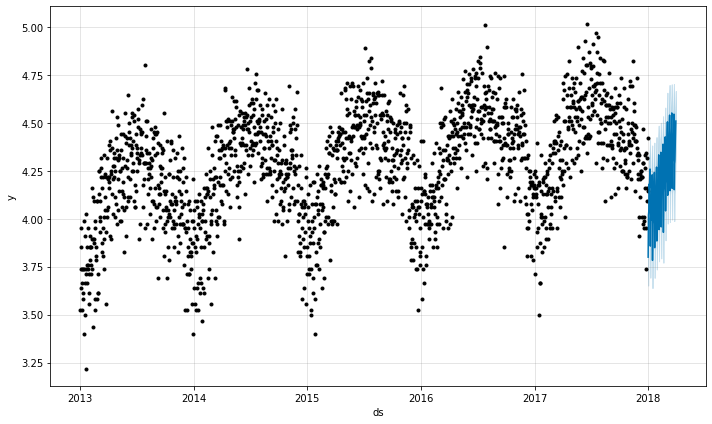

In [19]:
forecastplot = model.plot(forecast)

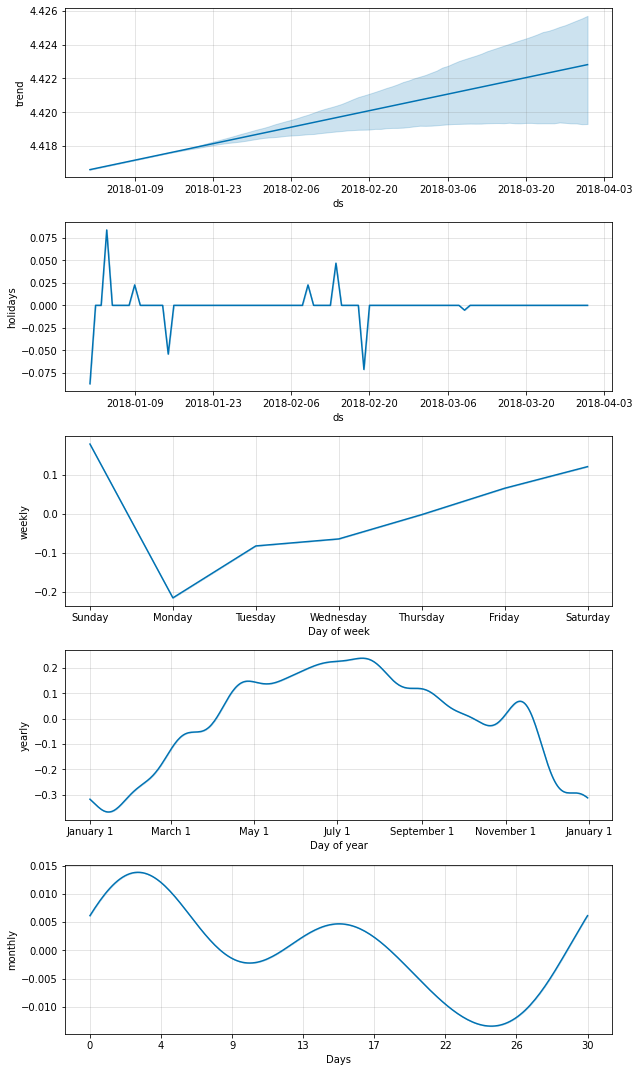

In [20]:
fig = model.plot_components(forecast)

## Ensembling Experiments (After Tuning)


> The improved catboost and Prophet models showed improvement to forecasting accuracy (observed in Experiment 6) - especially with a custom ratio of weighted average (60% catboost 40% prophet instead of 50-50 in Experiment 9). From ensembled learning before tuning, rounded sales figures showed better SMAPE scores, which is also applied for all experiments below. Experiment 10 showed that the ensembling of all 5 models did not produce the best result, possibly due to higher inaccuracies in forecasting for the pre-tuned models.



In [213]:
import pandas as pd
df1_1 = pd.read_csv("./submission_catboost.csv")
df1_2 = pd.read_csv("./submission_catboost_2.csv")
df1_3 = pd.read_csv("./submission_catboost_3.csv")
df2_1 = pd.read_csv("./submission_prophet_1.csv")
df2_2 = pd.read_csv("./submission_prophet_2.csv")

exp_df = df1_1 # make a duplicate for experiments

Experiment 5

In [211]:
exp_df['sales'] = (0.6*df1_1['sales']) + (0.4*df2_1['sales'])
exp_df.to_csv('submission_ens5.csv', index=False)
exp_df

,id,sales
0,0,11.710481
1,1,7.571615
2,2,9.698420
3,3,9.716022
4,4,10.350851
...,...,...
44995,44995,37.513748
44996,44996,43.853067
44997,44997,43.846570
44998,44998,47.272634


In [212]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('submission.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,8
2,2,10
3,3,10
4,4,10
...,...,...
44995,44995,38
44996,44996,44
44997,44997,44
44998,44998,47


Experiment 6 - BEST

In [214]:
exp_df['sales'] = (0.6*df1_2['sales']) + (0.4*df2_2['sales'])
exp_df

,id,sales
0,0,15.953810
1,1,12.930063
2,2,15.120669
3,3,15.488165
4,4,16.061055
...,...,...
44995,44995,64.469892
44996,44996,71.293805
44997,44997,73.940971
44998,44998,79.605310


In [215]:
#exp_df_rounded = exp_df
#exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int)
exp_df.to_csv('submission.csv', index=False)
#exp_df_rounded

Experiment 7 - SECOND BEST

In [206]:
exp_df['sales'] = (0.6*df1_2['sales']) + (0.4*df2_1['sales'])
exp_df

,id,sales
0,0,11.996981
1,1,8.240682
2,2,10.294504
3,3,10.317122
4,4,10.511106
...,...,...
44995,44995,37.497066
44996,44996,43.781670
44997,44997,44.399709
44998,44998,47.666984


In [203]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df.to_csv('submission.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,8
2,2,10
3,3,10
4,4,11
...,...,...
44995,44995,37
44996,44996,44
44997,44997,44
44998,44998,48


Experiment 8

In [180]:
exp_df['sales'] = (0.6*df1_3['sales']) + (0.4*df2_1['sales'])
exp_df

,id,sales
0,0,11.585372
1,1,8.503696
2,2,10.179885
3,3,10.279745
4,4,10.629433
...,...,...
44995,44995,37.345696
44996,44996,43.579135
44997,44997,43.889192
44998,44998,47.303307


In [181]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('submission_ens8_rounded.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,9
2,2,10
3,3,10
4,4,11
...,...,...
44995,44995,37
44996,44996,44
44997,44997,44
44998,44998,47


Experiment 9

In [182]:
exp_df['sales'] = (0.5*df1_2['sales']) + (0.5*df2_2['sales'])
exp_df

,id,sales
0,0,15.444967
1,1,13.162732
2,2,15.069651
3,3,15.524776
4,4,16.162915
...,...,...
44995,44995,65.663149
44996,44996,71.598718
44997,44997,74.653293
44998,44998,80.383811


In [183]:
import numpy as np
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('submission_ens9_rounded.csv', index=False)
exp_df_rounded

,id,sales
0,0,15
1,1,13
2,2,15
3,3,16
4,4,16
...,...,...
44995,44995,66
44996,44996,72
44997,44997,75
44998,44998,80


Experiment 10

In [184]:
exp_df['sales'] = (0.45*((df1_1['sales']+df1_2['sales']+df1_3['sales'])/3)) + (0.55*(((0.5*df2_1['sales'])+(0.5*df2_2['sales']))))
exp_df

,id,sales
0,0,11.918946
1,1,10.270963
2,2,11.648788
3,3,12.077386
4,4,12.479793
...,...,...
44995,44995,48.623588
44996,44996,53.074825
44997,44997,55.158456
44998,44998,59.250847


In [185]:
exp_df_rounded = exp_df
exp_df_rounded['sales'] = np.round(exp_df_rounded['sales']).astype(int) # round the result to whole number
exp_df_rounded.to_csv('submission.csv', index=False)
exp_df_rounded

,id,sales
0,0,12
1,1,10
2,2,12
3,3,12
4,4,12
...,...,...
44995,44995,49
44996,44996,53
44997,44997,55
44998,44998,59
